In [3]:
%matplotlib inline
import os
from cca_zoo.models import CCA
from cca_zoo.data import generate_covariance_data
from cca_zoo.models import rCCA
from cca_zoo.model_selection import GridSearchCV
from cca_zoo.deepmodels import architectures
import seaborn as sns
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
os.chdir('../raw_data')

#### Functions to load and or write to pickle files

In [4]:
class Files:
    def __init__(self, filename):
        self.file = filename
        
    def write_to_file(self, data):
        with open(self.file, 'wb') as f:
            pickle.dump(data, f) 
        return None
    
    def load_pickle(self):
        data = pd.read_pickle(self.file)
        return data
    
    def load_csv(self, sep, usecols=None):
        data = pd.read_csv(self.file, sep=sep, usecols=usecols)
        return data
        
        
    

In [5]:
os.listdir()

['ALL_GNPS.json',
 'ALL_GNPS_15_12_2021_positive_annotated.pickle',
 'ALL_GNPS_15_12_2021_positive_annotated_classifications.txt',
 'all_spec_embedding.pickle',
 'df_classes_all_embeddings.pickle',
 'GNPS_15_12_2021_ms2ds_embeddings.pickle',
 'model_300dim.pkl',
 'mol2vec_embedding.pickle',
 'ms2ds_embeddings_unique_GNPS_15_12_2021.pickle',
 'ms2ds_model_GNPS_15_12_2021.hdf5',
 'plot_validation.py',
 'spec2vec_embeddings_unique_GNPS_15_12_2021.pickle',
 'spec2vec_model_GNPS_15_12_2021.model',
 'spec2vec_model_GNPS_15_12_2021.model.syn1neg.npy',
 'spec2vec_model_GNPS_15_12_2021.model.wv.vectors.npy',
 'spectra_unique_GNPS_15_12_2021.pickle']

In [12]:
# load df with all info
path = './df_classes_all_embeddings.pickle'
df_all = Files(path).load_pickle()#[:10000] #just a subset for scripting
df_all.head()

,smiles,inchi_key,inchikey14,spec_id,spec2vec,ms2ds,mol2vec,cf_class
0,CC(C)CC1NC(=O)C(C)NC(=O)C(=C)N(C)C(=O)CCC(NC(=...,IYDKWWDUBYWQGF-NNAZGLEUSA-N,IYDKWWDUBYWQGF,CCMSLIB00000001547,"[-22.561352524375522, -52.61297182073491, 49.4...","[0.0, 15.901464462280273, 37.367000579833984, ...","[1.630672, -6.694838, -8.602699, 8.267098, 5.2...",Peptidomimetics
1,CCC[C@@H](C)[C@@H]([C@H](C)[C@@H]1[C@H]([C@H](...,KNGPFNUOXXLKCN-ZNCJFREWSA-N,KNGPFNUOXXLKCN,CCMSLIB00000001548,"[-8.144101929166954, -25.09254423476226, -1.49...","[0.0, 3.6031694412231445, 12.245128631591797, ...","[-2.5071416, -7.008046, -7.7435217, 3.9533424,...",Peptidomimetics
2,CCCCCCC[C@@H](C/C=C/CCC(=O)NC/C(=C/Cl)/[C@@]12...,WXDBUBIFYCCNLE-NSCMQRKRSA-N,WXDBUBIFYCCNLE,CCMSLIB00000001549,"[-6.807433213493404, 2.8870356459664226, -4.28...","[28.570608139038086, 7.199506759643555, 10.875...","[-5.2424912, -4.194231, -4.1477222, -1.4712936...",Oxepanes
3,CCCCCCC[C@@H](C/C=C/CCC(=O)NC/C(=C/Cl)/[C@@]12...,WXDBUBIFYCCNLE-NSCMQRKRSA-N,WXDBUBIFYCCNLE,CCMSLIB00000071752,"[-3.703751099226352, -2.2908253516762493, 6.72...","[17.48873519897461, 0.0, 29.71199607849121, 0....","[-5.2424912, -4.194231, -4.1477222, -1.4712936...",Oxepanes
4,OC1=CC=C(\C=C2\C(=O)C(C3=C4C5=C(C=CC=C5)N=C4\C...,CGZKSPLDUIRCIO-RPCRKUJJSA-N,CGZKSPLDUIRCIO,CCMSLIB00000001550,"[-10.171258233684286, 7.6353667714294735, 4.62...","[0.0, 3.3309712409973145, 14.854373931884766, ...","[3.6706285, -0.5248031, -10.340071, 15.618862,...",Indoles and derivatives


In [14]:
class RunCCA:
    def __init__(self, view1, view2,dims=2):
        self.v1 = view1
        self.v2 = view2
        self.dims = dims
    
    def train_cca(self):
        # step 0: init the model
        linear_cca = CCA(latent_dims=self.dims)
        
        # step 1: train (fit and transform)
        train_z1, train_z2 = linear_cca.fit_transform([self.v1, self.v2])
        
        #step 3: extract correlation between the dims of the 2 views
        train_corr = linear_cca.score([self.v1, self.v2])
        
        # bundle them in dfs
        
        # 1 latent_spaces
        train_latent_spaces = pd.DataFrame(list(zip(train_z1,train_z2)),\
                      columns=['train_z1','train_z2'])
        
        # 2 corr pd for plotting
        dims = [i for i in range(1,self.dims+1)] # adding 1 to start from 1
        train_cor_df = pd.DataFrame(list(zip(dims,train_corr)),\
                      columns=['latent_dim','cor'])
        
        return linear_cca, train_latent_spaces, train_cor_df
        
    def test_cca(self, model):
            
            
        # transform the test dataset
        test_z1, test_z2 = model.transform([self.v1,self.v2])
        test_corr = model.score([self.v1, self.v2])
            
        # bundle them in dfs
        
        # 1 latent_spaces
        test_latent_spaces = pd.DataFrame(list(zip(test_z1,test_z2)),\
                      columns=['test_z1','test_z2'])
        
        # 2 corr pd for plotting
        dims = [i for i in range(1,self.dims+1)] # adding 1 to start from 1
        test_cor_df = pd.DataFrame(list(zip(dims,test_corr)),\
                          columns=['latent_dim','cor'])
        
        return test_latent_spaces, test_cor_df
         

### Train A CCA model with MS2DeepScore embeddings

(288130, 8)

In [21]:
#split the dataset
train_df, test_df = \
train_test_split(df_all, test_size=0.3, random_state=42, stratify=df_all['inchikey14'])

v1_train, v1_test = [x for x in train_df['ms2ds']], [x for x in test_df['ms2ds']]
v2_train, v2_test = [x for x in train_df['mol2vec']], [x for x in test_df['mol2vec']]

In [22]:
# train the model
model, train_dim, train_corr = RunCCA(v1_train, v2_train, dims=200).train_cca()
train_corr.head()

,latent_dim,cor
0,1,0.818401
1,2,0.355394
2,3,0.344215
3,4,0.292364
4,5,0.208271


In [23]:
# test the model
test_dims, test_corr = RunCCA(v1_test, v2_test,dims=200).test_cca(model)
test_corr.head()

,latent_dim,cor
0,1,0.816807
1,2,0.354261
2,3,0.339298
3,4,0.288477
4,5,0.198902


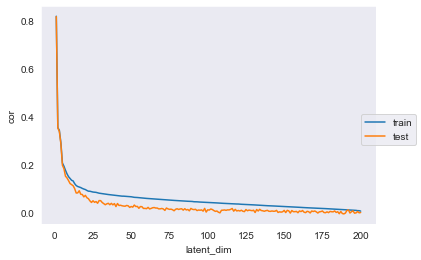

In [24]:
# plot train correlation vs test correlation
fig, ax = plt.subplots()
sns.set_style('dark')
dfs = [train_corr,test_corr]
for df in dfs:
    sns.lineplot(data = df, x='latent_dim',y='cor',ax=ax)
fig.legend(labels=['train', 'test'], loc='center right')
plt.show()

In [ ]:
#Think of importing plot_validation 